# Commonlit Homework Andrii Shevtsov

## Imports and constants

In [149]:
!pip install lightgbm optuna

In [163]:
import re
import ipywidgets as widgets

import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import gensim
import optuna
import string

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor
from tqdm import tqdm

%matplotlib inline

In [146]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
SUMMARIES_TRAIN_FILE = '../../data/commonlit_evaluate_student_summaries/summaries_train.csv'
SUMMARIES_TEST_FILE = '../../data/commonlit_evaluate_student_summaries/summaries_test.csv'
PROMPTS_TRAIN_FILE = '../../data/commonlit_evaluate_student_summaries/prompts_train.csv'
PROMPTS_TEST_FILE = '../../data/commonlit_evaluate_student_summaries/prompts_test.csv'

## Datasets import

In [3]:
summaries_train_df = pd.read_csv(SUMMARIES_TRAIN_FILE)
summaries_test_df = pd.read_csv(SUMMARIES_TEST_FILE)
prompts_train_df = pd.read_csv(PROMPTS_TRAIN_FILE)
prompts_test_df = pd.read_csv(PROMPTS_TEST_FILE)

In [4]:
summaries_train_df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [5]:
prompts_train_df.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

## EDA

### Data Profiling using existing tools

In [6]:
profile = ProfileReport(summaries_train_df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data understanding

Target variable understanding:

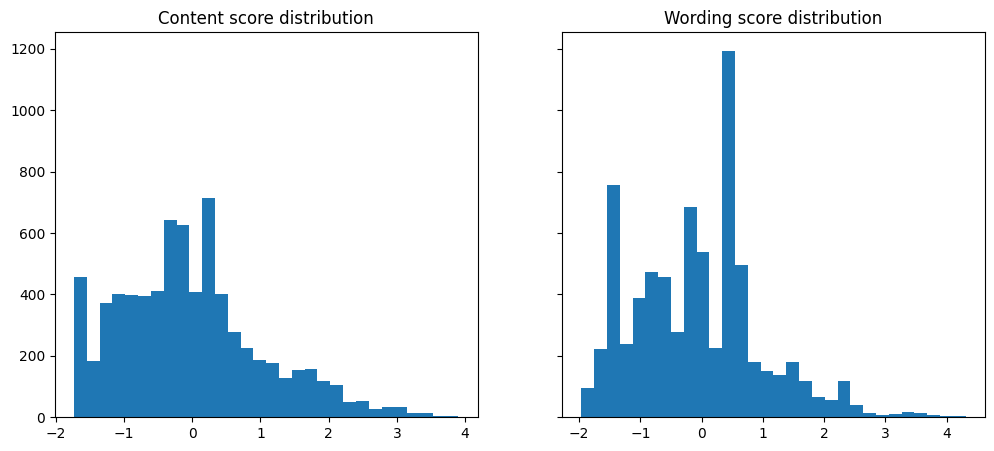

In [7]:
figure, axis = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axis[0].set_title(f"Content score distribution")
axis[0].hist(summaries_train_df.loc[:, 'content'], bins=30)

axis[1].set_title(f"Wording score distribution")
axis[1].hist(summaries_train_df.loc[:, 'wording'], bins=30)

plt.show()

In [8]:
summaries_train_df.describe()

content      wording
count  7165.000000  7165.000000
mean     -0.014853    -0.063072
std       1.043569     1.036048
min      -1.729859    -1.962614
25%      -0.799545    -0.872720
50%      -0.093814    -0.081769
75%       0.499660     0.503833
max       3.900326     4.310693

#### Sampling approach

Let's sample some extra values to see some patterns in data manually

In [9]:
# Standard layout patterns for widgets
layout=widgets.Layout(width='80%')
layout_half=widgets.Layout(width='40%')

In [10]:
def get_studanswer_values(row):
    '''
    Function to return values for widgets.HBox containing information about student summary
    '''
    return [
        widgets.Text(
            value=str(row['student_id'].iloc[0]),
            description='Student ID: ',
            disabled=True,
            layout=layout),
        widgets.Textarea(
            value=str(row['text'].iloc[0]),
            description='Summary text: ',
            disabled=True,
            layout=layout),
        widgets.HBox([
            widgets.Text(
            value=str(row['content'].iloc[0]),
            description='Content score: ',
            disabled=True,
            layout=layout_half),
            widgets.Text(
            value=str(row['wording'].iloc[0]),
            description='Wording score: ',
            disabled=True,
            layout=layout_half),
        ])
    ]

In [11]:
def get_selected_summaries(prompt_id):
    '''
    Get several summaries samples with different scores for one prompt
    '''
    prompt_summaries = summaries_train_df[summaries_train_df['prompt_id'] == prompt_id]
    
    great_boundary = 3.9
    bad_boundary = -1.9
    good_content_bad_wording_boundaries = [3.9, -1.9]
    bad_content_good_wording_boundaries = [-1.9, 3.9]
    delta = 0.1
    
    great_summaries = prompt_summaries[(prompt_summaries['content'] > great_boundary) & (prompt_summaries['wording'] > great_boundary)]
    while len(great_summaries) == 0:
        great_boundary -= delta
        great_summaries = prompt_summaries[(prompt_summaries['content'] > great_boundary) & (prompt_summaries['wording'] > great_boundary)]

    bad_summaries = prompt_summaries[(prompt_summaries['content'] < bad_boundary) & (prompt_summaries['wording'] < bad_boundary)]
    while len(bad_summaries) == 0:
        bad_boundary += delta
        bad_summaries = prompt_summaries[(prompt_summaries['content'] < bad_boundary) & (prompt_summaries['wording'] < bad_boundary)]

    good_content_bad_wording_summaries = prompt_summaries[(prompt_summaries['content'] > good_content_bad_wording_boundaries[0]) & (prompt_summaries['wording'] < good_content_bad_wording_boundaries[1])]
    while len(good_content_bad_wording_summaries) == 0:
        good_content_bad_wording_boundaries[0] -= delta
        good_content_bad_wording_boundaries[1] += delta
        good_content_bad_wording_summaries = prompt_summaries[(prompt_summaries['content'] > good_content_bad_wording_boundaries[0]) & (prompt_summaries['wording'] < good_content_bad_wording_boundaries[1])]
    
    bad_content_good_wording_summaries = prompt_summaries[(prompt_summaries['content'] < bad_content_good_wording_boundaries[0]) & (prompt_summaries['wording'] > bad_content_good_wording_boundaries[1])]
    while len(bad_content_good_wording_summaries) == 0:
        bad_content_good_wording_boundaries[0] += delta
        bad_content_good_wording_boundaries[1] -= delta
        bad_content_good_wording_summaries = prompt_summaries[(prompt_summaries['content'] < bad_content_good_wording_boundaries[0]) & (prompt_summaries['wording'] > bad_content_good_wording_boundaries[1])]

    return {'great': great_summaries.sample(), 'bad': bad_summaries.sample(),
           'good_content_bad_wording': good_content_bad_wording_summaries.sample(),
           'bad_content_good_wording': bad_content_good_wording_summaries.sample(),
           'all_prompt_summaries': prompt_summaries}

In [12]:
# Get options for dropdown to choose
dropdown_options={f"{prompt_id}: {prompt_title}":i for (i, prompt_id, prompt_title) in zip(prompts_train_df.index, prompts_train_df['prompt_id'], prompts_train_df['prompt_title'])}

dropdown = widgets.Dropdown(
    options=dropdown_options,
    description='Choose:',
    disabled=False,
    layout=layout
)

# Prompt properties widgets
id_text = widgets.Text(
    value=prompts_train_df.loc[0, 'prompt_id'],
    description='ID: ',
    disabled=True,
    layout=layout
)
title_text = widgets.Text(
    value=prompts_train_df.loc[0, 'prompt_title'],
    description='Title: ',
    disabled=True,
    layout=layout
)
question_text = widgets.Textarea(
    value=prompts_train_df.loc[0, 'prompt_question'],
    description='Question: ',
    disabled=True,
    layout=layout
)
text_text = widgets.Textarea(
    value=prompts_train_df.loc[0, 'prompt_text'],
    description='Text: ',
    disabled=True,
    layout=layout
)

# Prompt summaries samples widgets
selected_summaries = get_selected_summaries(prompts_train_df.loc[0, 'prompt_id'])
great_studanswer = widgets.VBox(children=get_studanswer_values(selected_summaries['great']))
bad_studanswer = widgets.VBox(children=get_studanswer_values(selected_summaries['bad']))
good_content_bad_wording_studanswer = widgets.VBox(children=get_studanswer_values(selected_summaries['good_content_bad_wording']))
bad_content_good_wording_studanswer = widgets.VBox(children=get_studanswer_values(selected_summaries['bad_content_good_wording']))

# Ouptut plot with scores
out_plot = widgets.Output()
with out_plot:
    plt.figure(figsize=(5, 3.5))
    plt.plot(selected_summaries['all_prompt_summaries']['content'], selected_summaries['all_prompt_summaries']['wording'], linewidth=0, marker='.')
    plt.title('Prompt scores distribution')
    plt.xlabel('Content scores')
    plt.ylabel('Wording scores')
    plt.grid()
    plt.show()

# Function to change text on dropdown item chosen
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        id_text.value = prompts_train_df.loc[change['new'], 'prompt_id']
        question_text.value = prompts_train_df.loc[change['new'], 'prompt_question']
        title_text.value = prompts_train_df.loc[change['new'], 'prompt_title']
        text_text.value = prompts_train_df.loc[change['new'], 'prompt_text']
        
        selected_summaries = get_selected_summaries(prompts_train_df.loc[change['new'], 'prompt_id'])
        great_studanswer.children  = get_studanswer_values(selected_summaries['great'])
        bad_studanswer.children = children=get_studanswer_values(selected_summaries['bad'])
        good_content_bad_wording_studanswer.children = children=get_studanswer_values(selected_summaries['good_content_bad_wording'])
        bad_content_good_wording_studanswer.children = children=get_studanswer_values(selected_summaries['bad_content_good_wording'])
        
        out_plot.clear_output()
        with out_plot:
            plt.figure(figsize=(5, 3.5))
            plt.plot(selected_summaries['all_prompt_summaries']['content'], selected_summaries['all_prompt_summaries']['wording'], linewidth=0, marker='.')
            plt.title('Prompt scores distribution')
            plt.xlabel('Content scores')
            plt.ylabel('Wording scores')
            plt.grid()
            plt.show()
            
dropdown.observe(on_change)


# The main item
widgets.VBox([dropdown,
              widgets.HTML(value="<h1 style='font-size:40px'>Chosen prompt info</h1>"),
              id_text,
              title_text,
              question_text,
              text_text,
              widgets.HTML(value="<h2 style='font-size:30px'>Students answers samples</h2>"),
              widgets.HTML(value="<h3 style='font-size:20px'>Great answer sample</h3>"),
              great_studanswer,
              widgets.HTML(value="<h3 style='font-size:20px'>Good wording, bad content</h3>"),
              bad_content_good_wording_studanswer,
              widgets.HTML(value="<h3 style='font-size:20px'>Good content, bad wording</h3>"),
              good_content_bad_wording_studanswer,
              widgets.HTML(value="<h3 style='font-size:20px'>Poor answer sample</h3>"),
              bad_studanswer,
              widgets.HTML(value="<h2 style='font-size:30px'>Students answer distribution for prompt</h2>"),
              out_plot
             ])


---

**Some outcomes:**
- Content score correlates with summary length.
- Distribution of scores is very similar for every prompt, but for some there are more outliers (better marks).


## Data preparation

### Prepare text

Preprocessing from the lecture

In [13]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'good', 'bad', 'people']) #stopwords extended a bit
def preprocess_hard(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
idx_picker = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(summaries_train_df) - 1,
    step=1,
    description='Index:',
    disabled=False
)

before_text = widgets.Textarea(
    value=summaries_train_df['text'].iloc[0],
    description='Unprocessed: ',
    disabled=True,
    layout=layout
)
preprocessed_text = widgets.Textarea(
    value=preprocess_hard(summaries_train_df['text'].iloc[0]),
    description='Preprocessed: ',
    disabled=True,
    layout=layout
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        before_text.value = summaries_train_df['text'].iloc[change['new']]
        preprocessed_text.value = preprocess_hard(summaries_train_df['text'].iloc[change['new']])
    
idx_picker.observe(on_change)

widgets.VBox([
    idx_picker,
    before_text,
    preprocessed_text
])


In [15]:
summaries_train_df['clean_text'] = summaries_train_df['text'].apply(preprocess_hard)
summaries_train_df

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0020ae56ffbf    ebad26   
2     004e978e639e    3b9047   
3     005ab0199905    3b9047   
4     0070c9e7af47    814d6b   
...            ...       ...   
7160  ff7c7e70df07    ebad26   
7161  ffc34d056498    3b9047   
7162  ffd1576d2e1b    3b9047   
7163  ffe4a98093b2    39c16e   
7164  fffbccfd8a08    ebad26   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     They would rub it up with soda to make the sme... -0.548304  0.506755   
2     In Egypt, there were many occupations and soci...  3.128928  4.231226   
3     The highest class was Pharaohs these people we... -0.210614 -0.471415   
4     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
...                                                 ...       ...       ...   
7160  They used all sorts of chemical concoctions to...  0.205683  0.380538   
7161  The lowest classes are slaves and farmers slav... -0.308448  0.048171   
7162             they sorta made people start workin... -1.408180 -0.493603   
7163  An ideal tragety has three elements that make ... -0.393310  0.627128   
7164  The meat would smell sour but the would "rub i...  1.771596  0.547742   

                                             clean_text  
0     wave experimentto reacted new leader governmen...  
1     rub soda smell away wouldnt smell meat tossed ...  
2     egypt occupations social classes involved day ...  
3     highest class pharaohs gods nd highest class g...  
4     wave developed rapidly students genuinly belie...  
...                                                 ...  
7160  sorts chemical concoctions meat fine shown quo...  
7161  lowest classes slaves farmers slaves taken war...  
7162  sorta start working structour theyed barley go...  
7163  ideal tragety elements ideal start great trage...  
7164  meat smell sour rub soda away smell sell rotti...  

[7165 rows x 6 columns]

In [16]:
prompts_train_df['clean_prompt_question'] = prompts_train_df['prompt_question'].apply(preprocess_hard)
prompts_train_df['clean_prompt_title'] = prompts_train_df['prompt_title'].apply(preprocess_hard)
prompts_train_df['clean_prompt_text'] = prompts_train_df['prompt_text'].apply(preprocess_hard)

prompts_train_df

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  \
0  Chapter 13 \r\nAs the sequel to what has alrea...   
1  Egyptian society was structured like a pyramid...   
2  Background \r\nThe Third Wave experiment took ...   
3  With one member trimming beef in a cannery, an...   

                               clean_prompt_question  \
0  summarize elements ideal tragedy described ari...   
1  complete sentences summarize structure ancient...   
2  summarize wave developed short period time exp...   
3  summarize ways factory cover spoiled meat cite...   

          clean_prompt_title  \
0                    tragedy   
1  egyptian social structure   
2                       wave   
3             excerpt jungle   

                                   clean_prompt_text  
0  chapter sequel said proceed consider poet aim ...  
1  egyptian society structured like pyramid gods ...  
2  background wave experiment took place cubberle...  
3  member trimming beef cannery working sausage f...

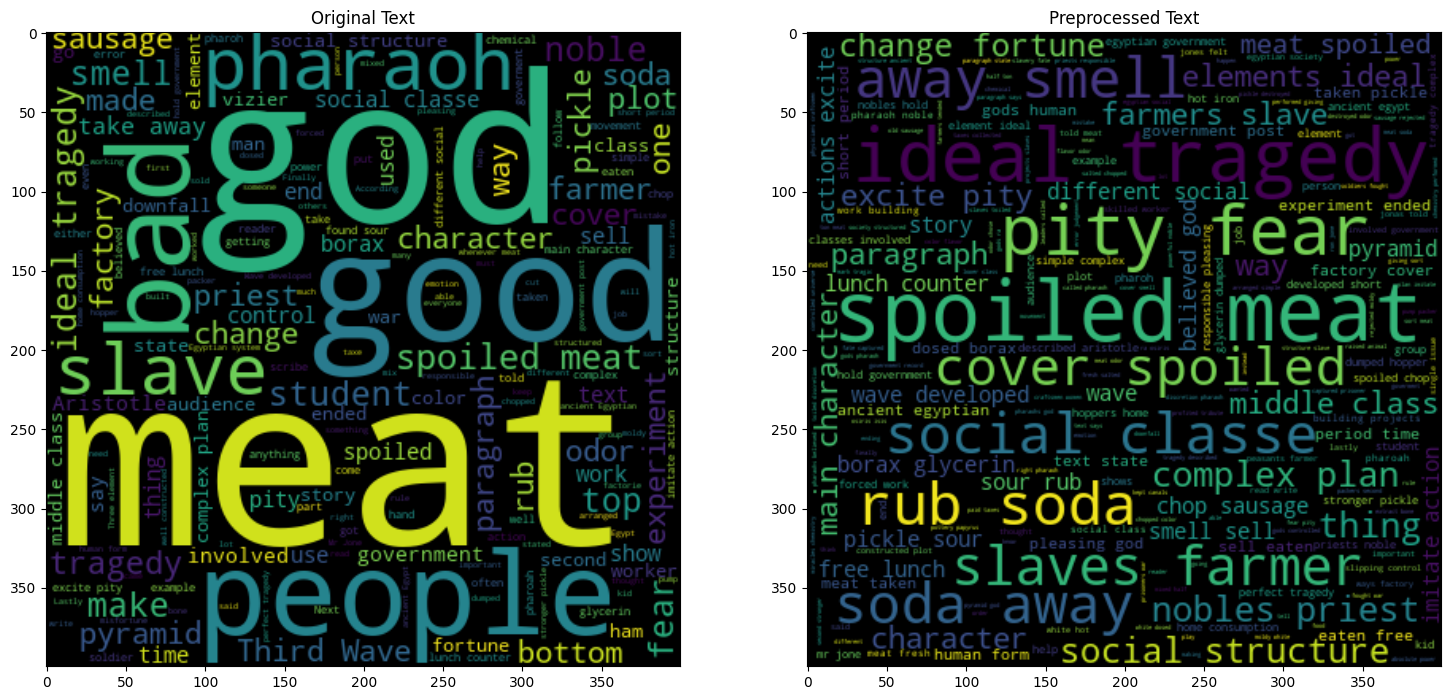

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (18,9))

axs[0].set_title("Original Text")
wc = WordCloud(max_words = 500 , width = 400 , height = 400).generate(" ".join(summaries_train_df['text']))
axs[0].imshow(wc, interpolation = 'bilinear')

axs[1].set_title("Preprocessed Text")
wc = WordCloud(max_words = 500 , width = 400 , height = 400).generate(" ".join(summaries_train_df['clean_text']))
axs[1].imshow(wc, interpolation = 'bilinear')

plt.show()

Preprocessing made words frequencies smoother!

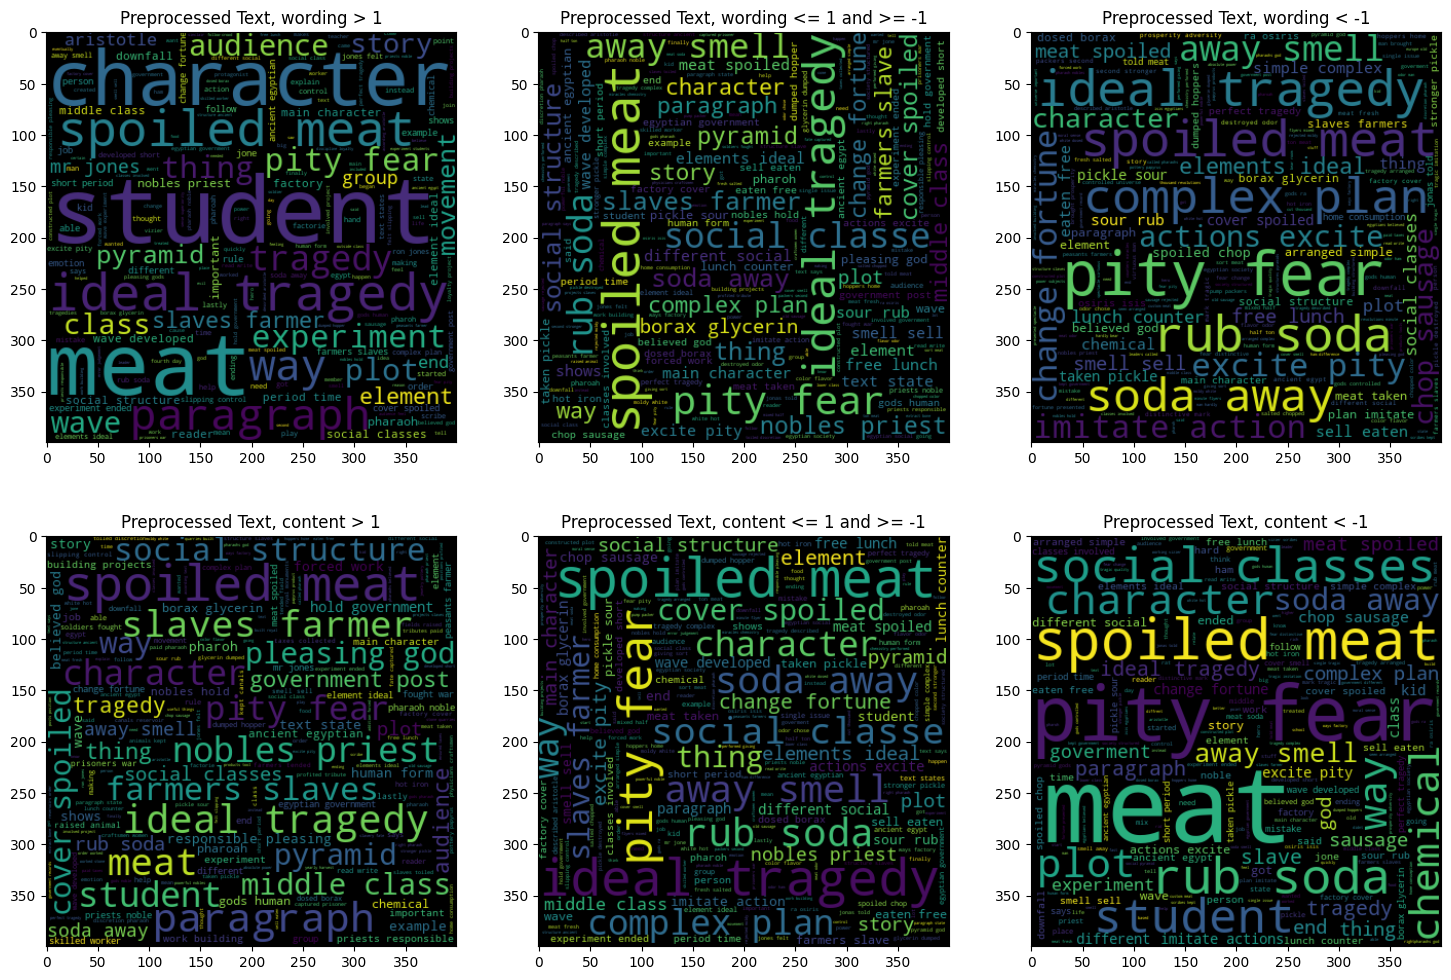

In [18]:
fig, axs = plt.subplots(2, 3, figsize = (18,12))

axs[0][0].set_title("Preprocessed Text, wording > 1")
wc = WordCloud(max_words = 200 , width = 400 , height = 400).generate(" ".join(summaries_train_df.loc[summaries_train_df['wording'] > 1, 'clean_text']))
axs[0][0].imshow(wc, interpolation = 'bilinear')

axs[0][1].set_title("Preprocessed Text, wording <= 1 and >= -1")
wc = WordCloud(max_words = 200 , width = 400 , height = 400).generate(" ".join(summaries_train_df.loc[(summaries_train_df['wording'] <= 1)&(summaries_train_df['wording'] >= -1), 'clean_text']))
axs[0][1].imshow(wc, interpolation = 'bilinear')

axs[0][2].set_title("Preprocessed Text, wording < -1")
wc = WordCloud(max_words = 200 , width = 400 , height = 400).generate(" ".join(summaries_train_df.loc[summaries_train_df['wording'] < -1, 'clean_text']))
axs[0][2].imshow(wc, interpolation = 'bilinear')

axs[1][0].set_title("Preprocessed Text, content > 1")
wc = WordCloud(max_words = 200 , width = 400 , height = 400).generate(" ".join(summaries_train_df.loc[summaries_train_df['content'] > 1, 'clean_text']))
axs[1][0].imshow(wc, interpolation = 'bilinear')

axs[1][1].set_title("Preprocessed Text, content <= 1 and >= -1")
wc = WordCloud(max_words = 200 , width = 400 , height = 400).generate(" ".join(summaries_train_df.loc[(summaries_train_df['content'] <= 1)&(summaries_train_df['content'] >= -1), 'clean_text']))
axs[1][1].imshow(wc, interpolation = 'bilinear')

axs[1][2].set_title("Preprocessed Text, content < -1")
wc = WordCloud(max_words = 200 , width = 400 , height = 400).generate(" ".join(summaries_train_df.loc[summaries_train_df['content'] < -1, 'clean_text']))
axs[1][2].imshow(wc, interpolation = 'bilinear')

plt.show()

In [19]:
summaries_train_df['clean_text_length_words'] = summaries_train_df['clean_text'].apply(lambda x: len(nltk.tokenize.word_tokenize(x)))
summaries_train_df["clean_text_length_symbols"] = summaries_train_df["clean_text"].apply(len)
summaries_train_df["clean_text_mean_word_length"] = (summaries_train_df["clean_text_length_symbols"] - summaries_train_df['clean_text_length_words'] + 1) / summaries_train_df['clean_text_length_words']
summaries_train_df

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0020ae56ffbf    ebad26   
2     004e978e639e    3b9047   
3     005ab0199905    3b9047   
4     0070c9e7af47    814d6b   
...            ...       ...   
7160  ff7c7e70df07    ebad26   
7161  ffc34d056498    3b9047   
7162  ffd1576d2e1b    3b9047   
7163  ffe4a98093b2    39c16e   
7164  fffbccfd8a08    ebad26   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     They would rub it up with soda to make the sme... -0.548304  0.506755   
2     In Egypt, there were many occupations and soci...  3.128928  4.231226   
3     The highest class was Pharaohs these people we... -0.210614 -0.471415   
4     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
...                                                 ...       ...       ...   
7160  They used all sorts of chemical concoctions to...  0.205683  0.380538   
7161  The lowest classes are slaves and farmers slav... -0.308448  0.048171   
7162             they sorta made people start workin... -1.408180 -0.493603   
7163  An ideal tragety has three elements that make ... -0.393310  0.627128   
7164  The meat would smell sour but the would "rub i...  1.771596  0.547742   

                                             clean_text  \
0     wave experimentto reacted new leader governmen...   
1     rub soda smell away wouldnt smell meat tossed ...   
2     egypt occupations social classes involved day ...   
3     highest class pharaohs gods nd highest class g...   
4     wave developed rapidly students genuinly belie...   
...                                                 ...   
7160  sorts chemical concoctions meat fine shown quo...   
7161  lowest classes slaves farmers slaves taken war...   
7162  sorta start working structour theyed barley go...   
7163  ideal tragety elements ideal start great trage...   
7164  meat smell sour rub soda away smell sell rotti...   

      clean_text_length_words  clean_text_length_symbols  \
0                          28                        203   
1                          14                         84   
2                         101                        737   
3                          14                         98   
4                          87                        670   
...                       ...                        ...   
7160                       25                        175   
7161                       23                        165   
7162                       25                        161   
7163                       26                        165   
7164                       42                        257   

      clean_text_mean_word_length  
0                        6.285714  
1                        5.071429  
2                        6.306931  
3                        6.071429  
4                        6.712644  
...                           ...  
7160                     6.040000  
7161                     6.217391  
7162                     5.480000  
7163                     5.384615  
7164                     5.142857  

[7165 rows x 9 columns]

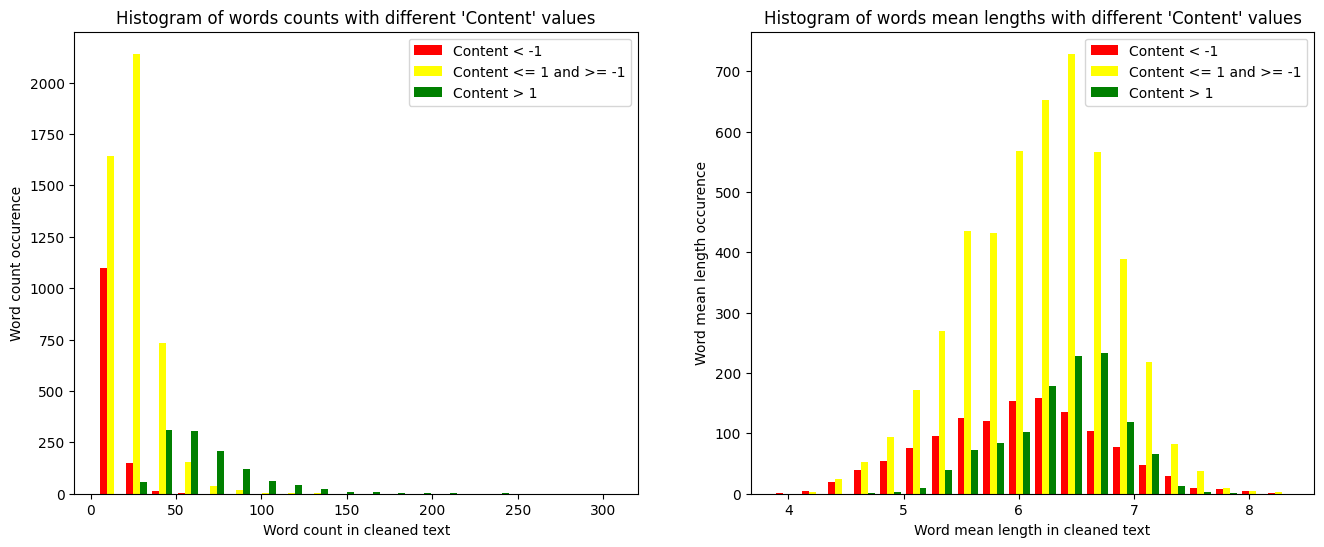

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))

axs[0].set_title("Histogram of words counts with different 'Content' values")
xs = [summaries_train_df.loc[summaries_train_df['content'] < -1, 'clean_text_length_words'], 
      summaries_train_df.loc[(summaries_train_df['content'] <= 1)&(summaries_train_df['content'] >= -1), 'clean_text_length_words'], 
      summaries_train_df.loc[summaries_train_df['content'] > 1, 'clean_text_length_words']]
labels=["Content < -1", "Content <= 1 and >= -1", "Content > 1"]
colors=['red', 'yellow', 'green']
axs[0].hist(xs, bins=20, label=labels, histtype='bar', color=colors)
axs[0].set_xlabel("Word count in cleaned text")
axs[0].set_ylabel("Word count occurence")
axs[0].legend()

axs[1].set_title("Histogram of words mean lengths with different 'Content' values")
xs = [summaries_train_df.loc[summaries_train_df['content'] < -1, 'clean_text_mean_word_length'], 
      summaries_train_df.loc[(summaries_train_df['content'] <= 1)&(summaries_train_df['content'] >= -1), 'clean_text_mean_word_length'], 
      summaries_train_df.loc[summaries_train_df['content'] > 1, 'clean_text_mean_word_length']]
labels=["Content < -1", "Content <= 1 and >= -1", "Content > 1"]
colors=['red', 'yellow', 'green']
axs[1].hist(xs, bins=20, label=labels, histtype='bar', color=colors)
axs[1].set_xlabel("Word mean length in cleaned text")
axs[1].set_ylabel("Word mean length occurence")
axs[1].legend()

plt.show()

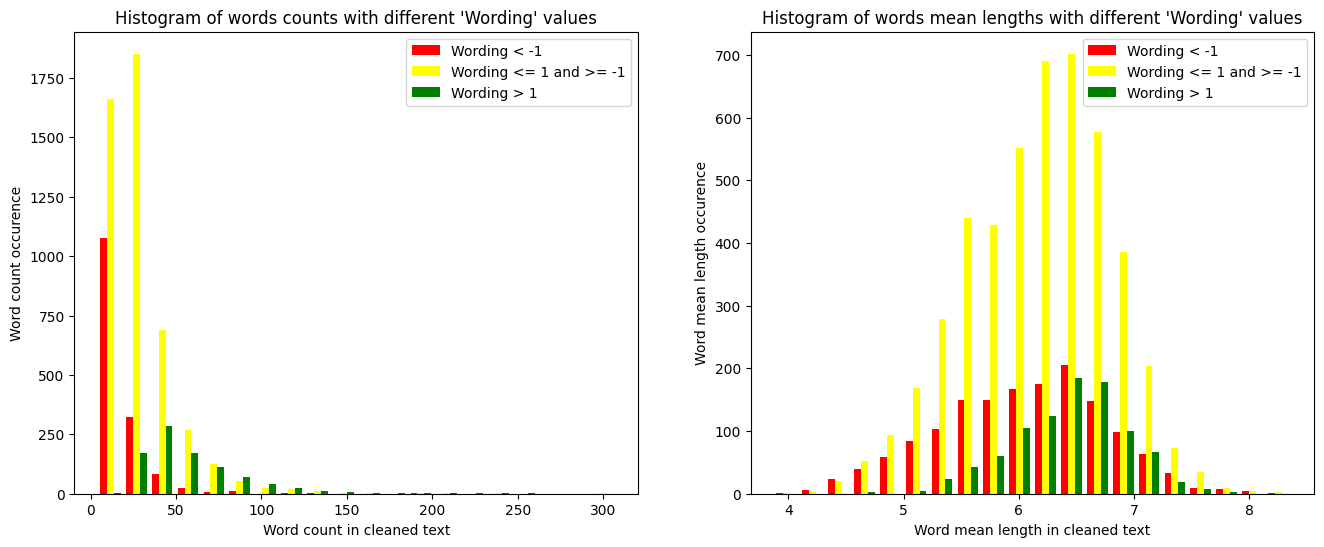

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))

axs[0].set_title("Histogram of words counts with different 'Wording' values")
xs = [summaries_train_df.loc[summaries_train_df['wording'] < -1, 'clean_text_length_words'], 
      summaries_train_df.loc[(summaries_train_df['wording'] <= 1)&(summaries_train_df['wording'] >= -1), 'clean_text_length_words'], 
      summaries_train_df.loc[summaries_train_df['wording'] > 1, 'clean_text_length_words']]
labels=["Wording < -1", "Wording <= 1 and >= -1", "Wording > 1"]
colors=['red', 'yellow', 'green']
axs[0].hist(xs, bins=20, label=labels, histtype='bar', color=colors)
axs[0].set_xlabel("Word count in cleaned text")
axs[0].set_ylabel("Word count occurence")
axs[0].legend()

axs[1].set_title("Histogram of words mean lengths with different 'Wording' values")
xs = [summaries_train_df.loc[summaries_train_df['wording'] < -1, 'clean_text_mean_word_length'], 
      summaries_train_df.loc[(summaries_train_df['wording'] <= 1)&(summaries_train_df['wording'] >= -1), 'clean_text_mean_word_length'], 
      summaries_train_df.loc[summaries_train_df['wording'] > 1, 'clean_text_mean_word_length']]
labels=["Wording < -1", "Wording <= 1 and >= -1", "Wording > 1"]
colors=['red', 'yellow', 'green']
axs[1].hist(xs, bins=20, label=labels, histtype='bar', color=colors)
axs[1].set_xlabel("Word mean length in cleaned text")
axs[1].set_ylabel("Word mean length occurence")
axs[1].legend()

plt.show()

Unexpectedly, but words count and word mean length influences "content" value much more than "wording".

### Features from the Commonlit authors

In [161]:
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def streamlit_feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [165]:
summaries_train_df = streamlit_feature_engineer(summaries_train_df)
summaries_train_df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                         clean_text  \
0  0.205683  0.380538  wave experimentto reacted new leader governmen...   
1 -0.548304  0.506755  rub soda smell away wouldnt smell meat tossed ...   
2  3.128928  4.231226  egypt occupations social classes involved day ...   
3 -0.210614 -0.471415  highest class pharaohs gods nd highest class g...   
4  3.272894  3.219757  wave developed rapidly students genuinly belie...   

   clean_text_length_words  clean_text_length_symbols  \
0                       28                        203   
1                       14                         84   
2                      101                        737   
3                       14                         98   
4                       87                        670   

   clean_text_mean_word_length  prompt_i  text_stopword_cnt  text_punct_cnt  \
0                     6.285714         2                 25               3   
1                     5.071429         3                 30               2   
2                     6.306931         1                 98              38   
3                     6.071429         1                 11               6   
4                     6.712644         2                 92              30   

   text_number_cnt  
0                0  
1                0  
2                0  
3                2  
4                3

## Modelling

### Preparation

In [22]:
prompts_train_df['merged_text'] = prompts_train_df['clean_prompt_title'] + '\n' + prompts_train_df['clean_prompt_question'] + '\n' + prompts_train_df['clean_prompt_text']
prompts_train_df

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  \
0  Chapter 13 \r\nAs the sequel to what has alrea...   
1  Egyptian society was structured like a pyramid...   
2  Background \r\nThe Third Wave experiment took ...   
3  With one member trimming beef in a cannery, an...   

                               clean_prompt_question  \
0  summarize elements ideal tragedy described ari...   
1  complete sentences summarize structure ancient...   
2  summarize wave developed short period time exp...   
3  summarize ways factory cover spoiled meat cite...   

          clean_prompt_title  \
0                    tragedy   
1  egyptian social structure   
2                       wave   
3             excerpt jungle   

                                   clean_prompt_text  \
0  chapter sequel said proceed consider poet aim ...   
1  egyptian society structured like pyramid gods ...   
2  background wave experiment took place cubberle...   
3  member trimming beef cannery working sausage f...   

                                         merged_text  
0  tragedy\nsummarize elements ideal tragedy desc...  
1  egyptian social structure\ncomplete sentences ...  
2  wave\nsummarize wave developed short period ti...  
3  excerpt jungle\nsummarize ways factory cover s...

In [166]:
prompts_ids_to_is = {prompt_id: i for i, prompt_id in zip(prompts_train_df.index, prompts_train_df['prompt_id'])}
summaries_train_df['prompt_i'] = summaries_train_df['prompt_id'].apply(lambda prompt_id: prompts_ids_to_is[prompt_id])
summaries_train_df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                         clean_text  \
0  0.205683  0.380538  wave experimentto reacted new leader governmen...   
1 -0.548304  0.506755  rub soda smell away wouldnt smell meat tossed ...   
2  3.128928  4.231226  egypt occupations social classes involved day ...   
3 -0.210614 -0.471415  highest class pharaohs gods nd highest class g...   
4  3.272894  3.219757  wave developed rapidly students genuinly belie...   

   clean_text_length_words  clean_text_length_symbols  \
0                       28                        203   
1                       14                         84   
2                      101                        737   
3                       14                         98   
4                       87                        670   

   clean_text_mean_word_length  prompt_i  text_stopword_cnt  text_punct_cnt  \
0                     6.285714         2                 25               3   
1                     5.071429         3                 30               2   
2                     6.306931         1                 98              38   
3                     6.071429         1                 11               6   
4                     6.712644         2                 92              30   

   text_number_cnt  
0                0  
1                0  
2                0  
3                2  
4                3

### Ridge linear model hyperparameters search

In [167]:
FEATURES_TO_SCALE = ['clean_text_length_words', 'clean_text_mean_word_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt']

In [170]:
def ridge_pipeline_evaluation(alpha, verbose=False):
    metrics_lists={'wording_train': [], 'wording_val': [], 'content_train': [], 'content_val': []}
    
    if verbose:
        print(f"Ridge starting, alpha={alpha}")
    
    for i in tqdm(range(len(prompts_train_df))):
        test_prompt_id = prompts_train_df.loc[i, 'prompt_id']
        summaries_train, summaries_val = summaries_train_df[~(summaries_train_df['prompt_id'] == test_prompt_id)], summaries_train_df[summaries_train_df['prompt_id'] == test_prompt_id]

        X_train, y_train = summaries_train.loc[:, ['prompt_i', 'clean_text', *FEATURES_TO_SCALE]], summaries_train.loc[:, ['content', 'wording']]
        X_val, y_val = summaries_val.loc[:, ['prompt_i', 'clean_text', *FEATURES_TO_SCALE]], summaries_val.loc[:, ['content', 'wording']]

        vectorizer = TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        )
        vectorizer = vectorizer.fit(X_train['clean_text'])
        train_summaries_vectors = vectorizer.transform(X_train['clean_text'])
        val_summaries_vectors = vectorizer.transform(X_val['clean_text'])
        merged_prompts_vectors = vectorizer.transform(prompts_train_df['merged_text'])

        scaler = RobustScaler().fit(X_train[FEATURES_TO_SCALE])
        X_train[FEATURES_TO_SCALE] = scaler.transform(X_train[FEATURES_TO_SCALE])
        X_val[FEATURES_TO_SCALE] = scaler.transform(X_val[FEATURES_TO_SCALE])

        y_content_scaler = RobustScaler().fit(y_train['content'].to_numpy().reshape(-1, 1))
        y_content_train_scaled = y_content_scaler.transform(y_train['content'].to_numpy().reshape(-1, 1))
        y_wording_scaler = RobustScaler().fit(y_train['wording'].to_numpy().reshape(-1, 1))
        y_wording_train_scaled = y_wording_scaler.transform(y_train['wording'].to_numpy().reshape(-1, 1))

        cosine_scores_train = (merged_prompts_vectors[X_train['prompt_i']] @ train_summaries_vectors.T).diagonal().reshape(-1, 1)
        cosine_scores_val = (merged_prompts_vectors[X_val['prompt_i']] @ val_summaries_vectors.T).diagonal().reshape(-1, 1)

        l2_scores_train = np.sum((merged_prompts_vectors[X_train['prompt_i']] - train_summaries_vectors).power(2), axis=1)
        l2_scores_val = np.sum((merged_prompts_vectors[X_val['prompt_i']] - val_summaries_vectors).power(2), axis=1)

        X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(cosine_scores_train),
            # sparse.coo_matrix(l2_scores_train),
            # sparse.coo_matrix(X_train['clean_text_length_words'].to_numpy().reshape(-1, 1)), 
            sparse.coo_matrix(X_train[FEATURES_TO_SCALE].to_numpy()),
        ))
        X_val = sparse.hstack((
            val_summaries_vectors,
            sparse.coo_matrix(cosine_scores_val),
            # sparse.coo_matrix(l2_scores_val),
            # sparse.coo_matrix(X_val['clean_text_length_words'].to_numpy().reshape(-1, 1)), 
            sparse.coo_matrix(X_val[FEATURES_TO_SCALE].to_numpy()),
        ))

        model_content = Ridge(alpha=alpha)
        model_content.fit(X_train, y_content_train_scaled)
        y_content_train_pred_scaled = model_content.predict(X_train)
        y_content_val_pred_scaled = model_content.predict(X_val)

        y_content_train_pred = y_content_scaler.inverse_transform(y_content_train_pred_scaled)
        y_content_val_pred = y_content_scaler.inverse_transform(y_content_val_pred_scaled)

        train_mse_content = mean_squared_error(y_content_train_pred, y_train['content'])
        val_mse_content = mean_squared_error(y_content_val_pred, y_val['content'])
        if verbose:
            print(f"Train MSE for content: {train_mse_content:.3f}, Val MSE for content: {val_mse_content:.3f}")
        metrics_lists['content_train'].append(train_mse_content)
        metrics_lists['content_val'].append(val_mse_content)
            
        model_wording = Ridge(alpha=alpha)
        model_wording.fit(X_train, y_wording_train_scaled)
        y_wording_train_pred_scaled = model_wording.predict(X_train)
        y_wording_val_pred_scaled = model_wording.predict(X_val)

        y_wording_train_pred = y_wording_scaler.inverse_transform(y_wording_train_pred_scaled)
        y_wording_val_pred = y_wording_scaler.inverse_transform(y_wording_val_pred_scaled)

        train_mse_wording = mean_squared_error(y_wording_train_pred, y_train['wording'])
        val_mse_wording = mean_squared_error(y_wording_val_pred, y_val['wording'])
        if verbose:
            print(f"Train MSE for wording: {train_mse_wording:.3f}, Val MSE for wording: {val_mse_wording:.3f}")
        metrics_lists['wording_train'].append(train_mse_wording)
        metrics_lists['wording_val'].append(val_mse_wording)
    
    metrics_avgs = {name: sum(metrics_list)/len(metrics_list) for name, metrics_list in metrics_lists.items()}
    return metrics_avgs

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.01s/it]


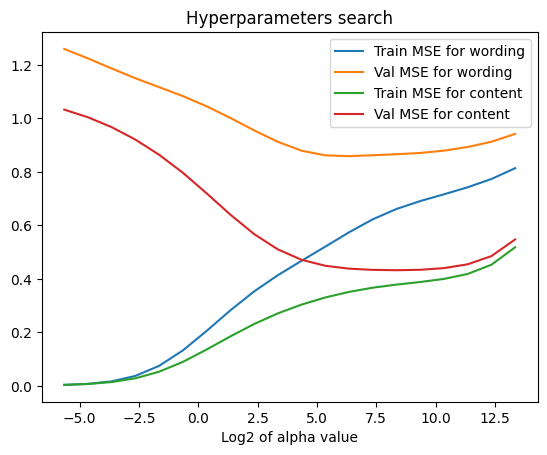

In [171]:
alphas = [0.02 * 2**i for i in range(0, 20)]
metrics_stats = {'wording_train': [], 'wording_val': [], 'content_train': [], 'content_val': []}

for alpha in alphas:
    metrics = ridge_pipeline_evaluation(alpha)
    for metric, metric_value in metrics.items():
        metrics_stats[metric].append(metric_value)

plt.title("Hyperparameters search")
plt.plot(np.log2(alphas), metrics_stats['wording_train'], label="Train MSE for wording")
plt.plot(np.log2(alphas), metrics_stats['wording_val'], label="Val MSE for wording")
plt.plot(np.log2(alphas), metrics_stats['content_train'], label="Train MSE for content")
plt.plot(np.log2(alphas), metrics_stats['content_val'], label="Val MSE for content")
plt.xlabel('Log2 of alpha value')
plt.legend()
plt.show()

**Then the best hyperparameters are approximately:**
- Alpha for wording: 30
- Alpha for content: 500

MCRMSE ≈ `0.8`

### LightGBM model evaluation

In [186]:
def lightgbm_pipeline_evaluation(params_content, params_wording, verbose=False):
    metrics_lists={'wording_train': [], 'wording_val': [], 'content_train': [], 'content_val': []}
    
    if verbose:
        print(f"LightGBM starting, param dict for content = {params_content}, param dict for wording = {params_wording}")
    
    for i in range(len(prompts_train_df)):
        test_prompt_id = prompts_train_df.loc[i, 'prompt_id']
        summaries_train, summaries_val = summaries_train_df[~(summaries_train_df['prompt_id'] == test_prompt_id)], summaries_train_df[summaries_train_df['prompt_id'] == test_prompt_id]

        X_train, y_train = summaries_train.loc[:, ['prompt_i', 'clean_text', *FEATURES_TO_SCALE]], summaries_train.loc[:, ['content', 'wording']]
        X_val, y_val = summaries_val.loc[:, ['prompt_i', 'clean_text', *FEATURES_TO_SCALE]], summaries_val.loc[:, ['content', 'wording']]

        vectorizer = TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        )
        vectorizer = vectorizer.fit(X_train['clean_text'])
        train_summaries_vectors = vectorizer.transform(X_train['clean_text'])
        val_summaries_vectors = vectorizer.transform(X_val['clean_text'])
        merged_prompts_vectors = vectorizer.transform(prompts_train_df['merged_text'])

        scaler = RobustScaler().fit(X_train[FEATURES_TO_SCALE])
        X_train[FEATURES_TO_SCALE] = scaler.transform(X_train[FEATURES_TO_SCALE])
        X_val[FEATURES_TO_SCALE] = scaler.transform(X_val[FEATURES_TO_SCALE])
        
        y_content_scaler = RobustScaler().fit(y_train['content'].to_numpy().reshape(-1, 1))
        y_content_train_scaled = y_content_scaler.transform(y_train['content'].to_numpy().reshape(-1, 1))
        y_wording_scaler = RobustScaler().fit(y_train['wording'].to_numpy().reshape(-1, 1))
        y_wording_train_scaled = y_wording_scaler.transform(y_train['wording'].to_numpy().reshape(-1, 1))

        cosine_scores_train = (merged_prompts_vectors[X_train['prompt_i']] @ train_summaries_vectors.T).diagonal().reshape(-1, 1)
        cosine_scores_val = (merged_prompts_vectors[X_val['prompt_i']] @ val_summaries_vectors.T).diagonal().reshape(-1, 1)

        # l2_scores_train = np.sum((merged_prompts_vectors[X_train['prompt_i']] - train_summaries_vectors).power(2), axis=1)
        # l2_scores_val = np.sum((merged_prompts_vectors[X_val['prompt_i']] - val_summaries_vectors).power(2), axis=1)

        X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(cosine_scores_train),
            # sparse.coo_matrix(l2_scores_train),
            sparse.coo_matrix(X_train['clean_text_length_words'].to_numpy().reshape(-1, 1)), 
            sparse.coo_matrix(X_train['clean_text_mean_word_length'].to_numpy().reshape(-1, 1)),
        ))
        X_val = sparse.hstack((
            val_summaries_vectors,
            sparse.coo_matrix(cosine_scores_val),
            # sparse.coo_matrix(l2_scores_val),
            sparse.coo_matrix(X_val['clean_text_length_words'].to_numpy().reshape(-1, 1)), 
            sparse.coo_matrix(X_val['clean_text_mean_word_length'].to_numpy().reshape(-1, 1)),
        ))

        model_content = LGBMRegressor(**params_content, verbose = -1)
        model_content.fit(X_train, y_content_train_scaled.ravel())
        y_content_train_pred_scaled = model_content.predict(X_train)
        y_content_val_pred_scaled = model_content.predict(X_val)

        y_content_train_pred = y_content_scaler.inverse_transform(y_content_train_pred_scaled.reshape(-1, 1))
        y_content_val_pred = y_content_scaler.inverse_transform(y_content_val_pred_scaled.reshape(-1, 1))

        train_mse_content = mean_squared_error(y_content_train_pred, y_train['content'])
        val_mse_content = mean_squared_error(y_content_val_pred, y_val['content'])
        if verbose:
            print(f"Train MSE for content: {train_mse_content:.3f}, Val MSE for content: {val_mse_content:.3f}")
        metrics_lists['content_train'].append(train_mse_content)
        metrics_lists['content_val'].append(val_mse_content)
            
        model_wording = LGBMRegressor(**params_wording, verbose = -1)
        model_wording.fit(X_train, y_wordingS_train_scaled.ravel())
        y_wording_train_pred_scaled = model_wording.predict(X_train)
        y_wording_val_pred_scaled = model_wording.predict(X_val)

        y_wording_train_pred = y_wording_scaler.inverse_transform(y_wording_train_pred_scaled.reshape(-1, 1))
        y_wording_val_pred = y_wording_scaler.inverse_transform(y_wording_val_pred_scaled.reshape(-1, 1))

        train_mse_wording = mean_squared_error(y_wording_train_pred, y_train['wording'])
        val_mse_wording = mean_squared_error(y_wording_val_pred, y_val['wording'])
        if verbose:
            print(f"Train MSE for wording: {train_mse_wording:.3f}, Val MSE for wording: {val_mse_wording:.3f}")
        metrics_lists['wording_train'].append(train_mse_wording)
        metrics_lists['wording_val'].append(val_mse_wording)
    
    metrics_avgs = {name: sum(metrics_list)/len(metrics_list) for name, metrics_list in metrics_lists.items()}
    return metrics_avgs

In [183]:
lightgbm_pipeline_evaluation({}, {}, verbose=True)

LightGBM starting, param dict for content = {}, param dict for wording = {}
Train MSE for content: 0.192, Val MSE for content: 0.692
Train MSE for wording: 0.390, Val MSE for wording: 1.201
Train MSE for content: 0.161, Val MSE for content: 0.684
Train MSE for wording: 0.332, Val MSE for wording: 1.544
Train MSE for content: 0.179, Val MSE for content: 0.715
Train MSE for wording: 0.322, Val MSE for wording: 2.149
Train MSE for content: 0.194, Val MSE for content: 0.362
Train MSE for wording: 0.403, Val MSE for wording: 0.521


{'wording_train': 0.3614318064887262,
 'wording_val': 1.3538545928858232,
 'content_train': 0.18152919701523404,
 'content_val': 0.6133087251683057}

Model tuning:

In [187]:
def objective(trial):
    param1 = {
        "metric": "rmse",
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1_1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2_1", 1e-8, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate_1", 1e-5, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves_1", 2, 256),
        "max_depth": trial.suggest_int("max_depth_1", 1, 4),
        "n_estimators": trial.suggest_int("n_estimators_1", 10, 200), 
        "feature_fraction": trial.suggest_float("feature_fraction_1", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction_1", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq_1", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples_1", 5, 100),
    }
    
    param2 = {
        "metric": "rmse",
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1_2", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2_2", 1e-8, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate_2", 1e-5, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves_2", 2, 256),
        "max_depth": trial.suggest_int("max_depth_2", 1, 4),
        "n_estimators": trial.suggest_int("n_estimators_2", 10, 200), 
        "feature_fraction": trial.suggest_float("feature_fraction_2", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction_2", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq_2", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples_2", 5, 100),
    }

    metrics_avgs = lightgbm_pipeline_evaluation(param1, param2)
    
    return (np.sqrt(metrics_avgs['wording_val']) + np.sqrt(metrics_avgs['content_val'])) / 2

In [188]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-10-02 01:34:58,680] A new study created in memory with name: no-name-420d17c8-d06f-45b4-8ae5-a467e1f15d61
[I 2023-10-02 01:35:14,112] Trial 0 finished with value: 0.8305330205078192 and parameters: {'lambda_l1_1': 0.10596193208125147, 'lambda_l2_1': 0.01070965114217504, 'learning_rate_1': 0.11930270263027132, 'num_leaves_1': 242, 'max_depth_1': 2, 'n_estimators_1': 21, 'feature_fraction_1': 0.7204203146105784, 'bagging_fraction_1': 0.9625290503112415, 'bagging_freq_1': 4, 'min_child_samples_1': 72, 'lambda_l1_2': 0.000117669561137978, 'lambda_l2_2': 2.6414240411153073e-08, 'learning_rate_2': 0.0014300078136171735, 'num_leaves_2': 177, 'max_depth_2': 2, 'n_estimators_2': 143, 'feature_fraction_2': 0.9555583407517497, 'bagging_fraction_2': 0.8878561842039763, 'bagging_freq_2': 20, 'min_child_samples_2': 15}. Best is trial 0 with value: 0.8305330205078192.
[I 2023-10-02 01:35:30,517] Trial 1 finished with value: 1.1508394538936872e+38 and parameters: {'lambda_l1_1': 0.001063736628

Number of finished trials: 50
Best trial: {'lambda_l1_1': 0.10099137201078609, 'lambda_l2_1': 0.22105301368601804, 'learning_rate_1': 0.032634431545309275, 'num_leaves_1': 49, 'max_depth_1': 1, 'n_estimators_1': 136, 'feature_fraction_1': 0.8299686618529685, 'bagging_fraction_1': 0.7811172396931929, 'bagging_freq_1': 2, 'min_child_samples_1': 41, 'lambda_l1_2': 1.407798387370405e-06, 'lambda_l2_2': 1.8397542453236796e-05, 'learning_rate_2': 0.022712974904138393, 'num_leaves_2': 82, 'max_depth_2': 1, 'n_estimators_2': 97, 'feature_fraction_2': 0.7612120399237623, 'bagging_fraction_2': 0.7344368498496404, 'bagging_freq_2': 16, 'min_child_samples_2': 55}


Parameters:
```json
{'lambda_l1_1': 0.10099137201078609, 'lambda_l2_1': 0.22105301368601804, 'learning_rate_1': 0.032634431545309275, 'num_leaves_1': 49, 'max_depth_1': 1, 'n_estimators_1': 136, 'feature_fraction_1': 0.8299686618529685, 'bagging_fraction_1': 0.7811172396931929, 'bagging_freq_1': 2, 'min_child_samples_1': 41, 'lambda_l1_2': 1.407798387370405e-06, 'lambda_l2_2': 1.8397542453236796e-05, 'learning_rate_2': 0.022712974904138393, 'num_leaves_2': 82, 'max_depth_2': 1, 'n_estimators_2': 97, 'feature_fraction_2': 0.7612120399237623, 'bagging_fraction_2': 0.7344368498496404, 'bagging_freq_2': 16, 'min_child_samples_2': 55}
```

MCRMSE = `0.76897`

Notebooks `commonlit_submission_lightgbm.ipynb` and `commonlit_submission_ridge.ipynb` are submitted to kaggle.

> Ridge notebook somehow fails at runtime without any ability to watch what is wrong. LightGBM is OK.

Their public leaderboard scores are:

![Leaderboard scores for notebooks](https://i.imgur.com/QLtgeZV.png)